# CYP2C9 & CYP2C19 multidms analysis

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Summary Stats

First load in the data and do a little cleanup

In [4]:
C19 = pd.read_csv("../data/CYP2C19_abundance.csv")
C9 = pd.read_csv("../data/CYP2C9_abundance.csv")

In [5]:
C19.query("replicate != 'Rep3'", inplace=True)

In [6]:
print(f"C9 replicates: {C9.replicate.unique()}")
print(f"C19 replicates: {C19.replicate.unique()}")

C9 replicates: ['Rep2' 'Rep3']
C19 replicates: ['Rep1' 'Rep2']


In [7]:
C9["replicate"] = C9.replicate.replace({"Rep2":"1", "Rep3":"2"})
C19["replicate"] = C19.replicate.replace({"Rep1":"1", "Rep2":"2"})

In [8]:
print(f"C9 replicates: {C9.replicate.unique()}")
print(f"C19 replicates: {C19.replicate.unique()}")

C9 replicates: ['1' '2']
C19 replicates: ['1' '2']


In [9]:
cols_to_keep = ["replicate", "barcode", "abundance_score", "variant"]

append df's and add condition id, rename for MultiDmsData

In [10]:
rename_map = {
    "variant" : "aa_substitutions"
}
func_score_df = pd.concat(
    [
        C19[cols_to_keep].assign(condition="C19"), 
        C9[cols_to_keep].assign(condition="C9")
    ]
).rename(rename_map,axis=1).reset_index(drop=True)

remove 'syn' mutants

In [11]:
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]

conform 'X' -> '*' for stop codon variants

In [12]:
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))

In [13]:
func_score_df

,replicate,barcode,abundance_score,aa_substitutions,condition
0,1,AAAAAAAACTACGTTCCA,1.125517,S162R,C19
1,1,AAAAAAAATCCTAGCCGT,0.582444,D373R,C19
2,1,AAAAAAAATTTTGAAAGA,0.494377,D360K,C19
3,1,AAAAAAACTATTGACTTC,0.814096,L71G,C19
4,1,AAAAAAATACAGGTTAAT,0.017776,E274*,C19
...,...,...,...,...,...
656337,2,TTTTTTTTGAAAGTCAAG,1.015779,K247A,C9
656338,2,TTTTTTTTGCCAACGAAG,0.804345,D191T,C9
656339,2,TTTTTTTTGTAATTCTTG,0.967191,Q193L,C9
656340,2,TTTTTTTTGTACGTACTT,0.262400,G332S,C9


Summary stats of quantitative columns

In [14]:
func_score_df.describe()

,abundance_score
count,629061.000000
mean,0.664900
std,0.353559
min,-0.701318
25%,0.392404
50%,0.718300
75%,0.938140
max,2.110753


In [15]:
func_score_df.condition.value_counts()

condition
C19    531188
C9      97873
Name: count, dtype: int64

In [16]:
func_score_df.query("condition == 'C19'").replicate.value_counts()

replicate
1    318813
2    212375
Name: count, dtype: int64

In [17]:
func_score_df.query("condition == 'C9'").replicate.value_counts()

replicate
1    48946
2    48927
Name: count, dtype: int64

## Functional scores distributions

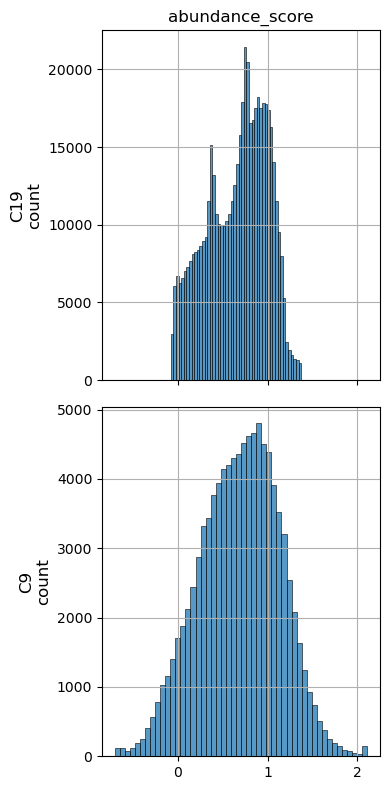

In [20]:
# targets = ["weighted_average", "abundance_score", "log_fold_wa"]
targets = ["abundance_score"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharex="col",
    figsize=[4, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    # for col, target in enumerate(targets):
    sns.histplot(condition_df, x=targets[0], ax=ax[row], bins=50)
    ax[row].grid()
    ax[row].set_xlabel("")
    ax[row].set_ylabel("")
    ax[row].set_ylabel(f"{condition}\ncount", size=12)
    if row == 0:
        ax[row].set_title(targets[0])
plt.tight_layout()
plt.show()

## Barcodes

In [21]:
! echo $(date -I)

2023-09-20


In [22]:
OUTDIR="../results/2023-09-20/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

First, we'll look at the number of barcodes per variant

In [23]:
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts().reset_index()
    print(condition,'\n',vc.describe())

C19 
              count
count  8472.000000
mean     62.699245
std      80.869279
min       1.000000
25%      15.000000
50%      35.000000
75%      79.000000
max    1835.000000
C9 
              count
count  8308.000000
mean     11.780573
std      12.594819
min       1.000000
25%       4.000000
50%       8.000000
75%      14.000000
max     172.000000


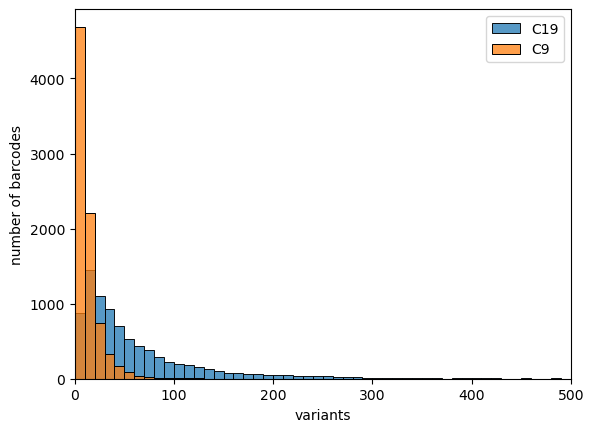

In [24]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts().reset_index()
    sns.histplot(vc, x="count", ax=ax, bins=range(0, 500, 10), label=condition)
    ax.set_ylabel("number of barcodes")
    ax.set_xlabel("variants")
    ax.set_xlim([0, 500])
    ax.legend()
fig.savefig(f"{OUTDIR}/barcodes.svg")

Next, let's look at the stoachasticity to expect by number of barcodes

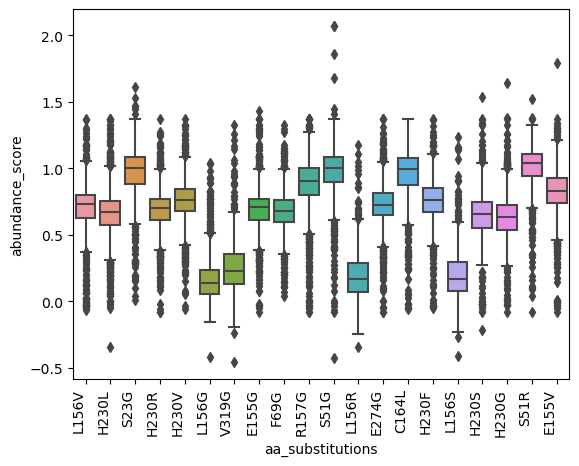

In [25]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[:20].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

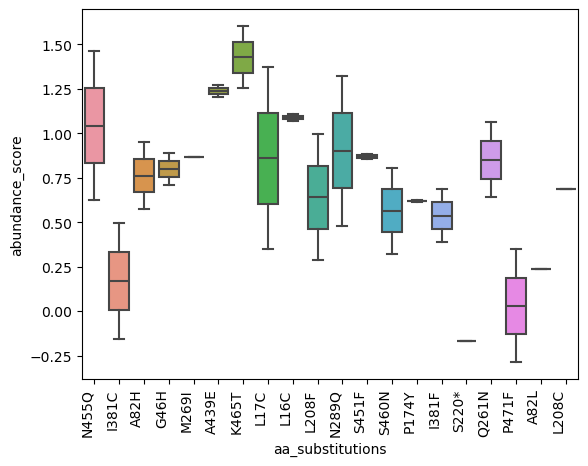

In [26]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[-20:].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

## Fit individual replicates and asses shift correlation

In [27]:
func_score_df

,replicate,barcode,abundance_score,aa_substitutions,condition
0,1,AAAAAAAACTACGTTCCA,1.125517,S162R,C19
1,1,AAAAAAAATCCTAGCCGT,0.582444,D373R,C19
2,1,AAAAAAAATTTTGAAAGA,0.494377,D360K,C19
3,1,AAAAAAACTATTGACTTC,0.814096,L71G,C19
4,1,AAAAAAATACAGGTTAAT,0.017776,E274*,C19
...,...,...,...,...,...
656337,2,TTTTTTTTGAAAGTCAAG,1.015779,K247A,C9
656338,2,TTTTTTTTGCCAACGAAG,0.804345,D191T,C9
656339,2,TTTTTTTTGTAATTCTTG,0.967191,Q193L,C9
656340,2,TTTTTTTTGTACGTACTT,0.262400,G332S,C9


In [28]:
target = "abundance_score"

In [30]:
rep_fits = pd.DataFrame()

for replicate, replicate_df in func_score_df.groupby("replicate"):

    data = multidms.Data(
        replicate_df.rename({target:"func_score"}, axis=1).reset_index(drop=True),
        reference = "C9",
        collapse_identical_variants = False,
        alphabet= multidms.AAS_WITHSTOP,
        verbose=True
    )

    for lock_beta_naught in [1., None]:

        data.condition_colors = {
            'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
            'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
        }
        
        fit_params = {
            'epistatic_model' : "Identity",
            'output_activation' : "Identity",
            'lock_beta_naught' : lock_beta_naught,
            'init_beta_naught' : 0.,
            'gamma_corrected' : False,
            'warmup_beta':False,
            'save_model_at':[20000],
            'num_training_steps': 10,
            'iterations_per_step': 2000,
            'tol' : 1e-5,
            'scale_coeff_lasso_shift' : 1e-5,
            'scale_coeff_ridge_beta' : 1e-6
        }
        
        start_t = time.time()
        fit = multidms.utils.fit_wrapper(data, **fit_params)
        fit["beta_naught"] = "free" if lock_beta_naught is None else lock_beta_naught
        fit["replicate"] = replicate
        fit["target"] = target
        
        rep_fits = pd.concat([rep_fits, fit], ignore_index=True)
        end_t = time.time()
        print(f"FINISHED total time: {round(end_t - start_t)} seconds")

print(f"Done")

inferring site map for C19


  0%|          | 0/318813 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/48946 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 197 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 3932 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping


I0000 00:00:1695237664.790161   19567 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f5ea86d4dd0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 2000,
 'lock_beta': False,
 'lock_beta_naught': 1.0,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'scale_coeff_lasso_shift': 1e-05,
 'scale_coeff_ridge_beta': 1e-06,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False}
training_step 0/10,Loss: 0.10223035866205782, Time: 10 Seconds
training_step 1/10,Loss: 0.076934530596421, Time: 7 Seconds
training_step 2/10,Loss: 0.07131352666928654, Time: 7 Seconds
training_step 3/10,Loss: 0.06932322709002196, Time: 7 Seconds
training_step 4/10,Loss: 0.06842208703762309, Time: 7 Seconds
training_step 5/10,Loss: 0.06794677509

  0%|          | 0/212375 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/48927 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 191 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 2989 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f5e895f9210>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 2000,
 'lock_beta': False,
 'lock_beta_naught': 1.0,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [20000],
 'scale_coeff_lasso_shift': 1e-05,
 'scale_coeff_ridge_beta': 1e-06,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-05,
 'warmup_beta': False}
training_step 0/10,Loss: 0.10460297046068717, Time: 7 Seconds
training_step 1/10,Loss: 0.07991722482258079, Time: 5 Seconds
training_step 2/10,Loss: 0.07460524177811825, Time: 5 Seconds
training_step 3/10,Loss: 0.07269050724722709, Time: 6 Seconds
training_step 4/10,Loss: 0.07183672625426747, Ti

In [31]:
rep_fits

,dataset,huber_scale_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_20000,beta_naught,replicate,target
0,<multidms.data.Data object at 0x7f5ea86d4dd0>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.10223035866205782, 0.076934530596421, 0.071...",<multidms.model.Model object at 0x7f5e896bd850>,1.0,1,abundance_score
1,<multidms.data.Data object at 0x7f5ea86d4dd0>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.09996332640098275, 0.0762100674538077, 0.07...",<multidms.model.Model object at 0x7f5e95784e10>,free,1,abundance_score
2,<multidms.data.Data object at 0x7f5e895f9210>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.10460297046068717, 0.07991722482258079, 0.0...",<multidms.model.Model object at 0x7f5e8ab08c10>,1.0,2,abundance_score
3,<multidms.data.Data object at 0x7f5e895f9210>,1,0.00001,0.000001,0,0,0,0,Identity,Identity,...,0.00001,10,2000,[20000],0,"[0.10170154513136637, 0.07923910555311942, 0.0...",<multidms.model.Model object at 0x7f5e8af0f010>,free,2,abundance_score


1.0


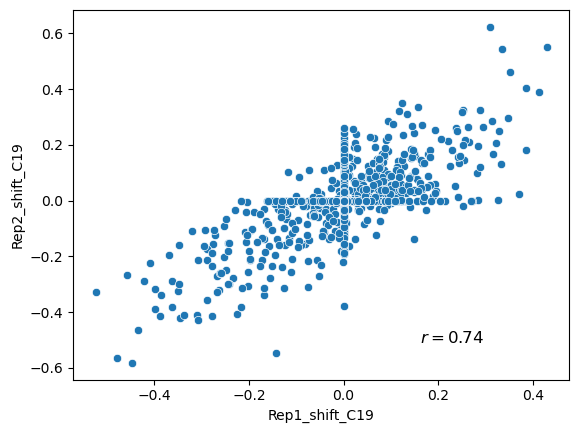

free


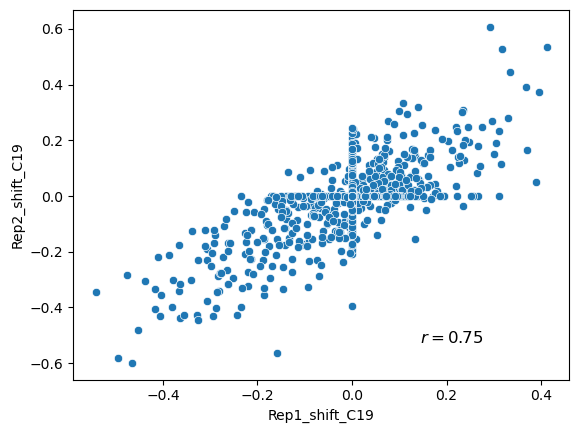

In [34]:
for beta_naught, fits in rep_fits.groupby("beta_naught"):
    print(beta_naught)
    
    fit_dict = {f"Rep{row.replicate}":row.model_20000 for _, row in fits.iterrows()}
    combined_rep_mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=10)
    fig, ax = plt.subplots()
    r = pearsonr(combined_rep_mut_df["Rep1_shift_C19"], combined_rep_mut_df["Rep2_shift_C19"])[0]
    ax = sns.scatterplot(combined_rep_mut_df, x="Rep1_shift_C19", y="Rep2_shift_C19")
    ax.annotate(f"$r = {r:.2f}$", (0.7, 0.1), xycoords="axes fraction", fontsize=12)
    fig.savefig(f"{OUTDIR}/correlation_beta_naught_{beta_naught}.pdf")
    plt.show()

1 1.0
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([-0.22532239,  0.1465872 , -0.08555519, ..., -0.07540185,
       -0.12588569,  0.12219882], dtype=float64), 'beta_naught': Array([1.], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0.11145402, -0.01251627,  0.        , ...,  0.        ,
        0.        ,  0.        ], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


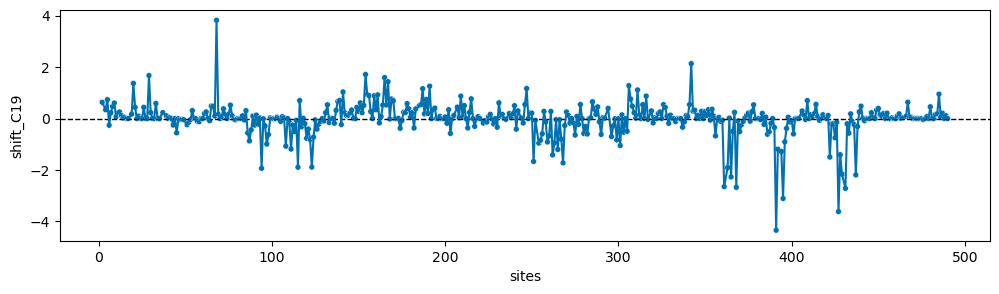

1 free
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([0.10570354, 0.4715651 , 0.24008407, ..., 0.24310542, 0.17865459,
       0.41448525], dtype=float64), 'beta_naught': Array([0.66648334], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0.09392224, -0.02409528,  0.        , ...,  0.        ,
        0.        ,  0.        ], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


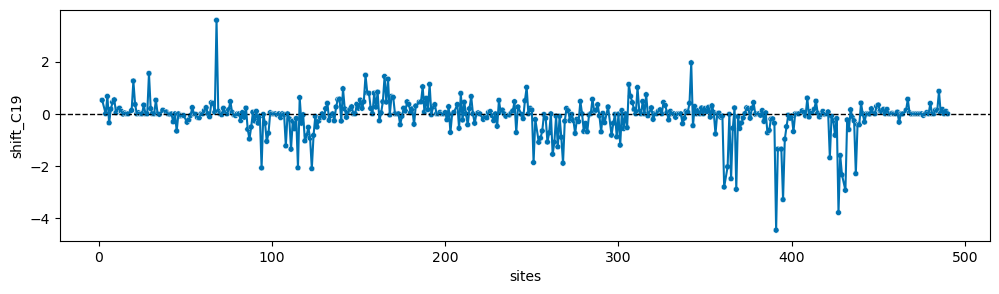

2 1.0
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([-0.19698311, -0.07065868,  0.02494078, ..., -0.08196396,
        0.00907796,  0.01289274], dtype=float64), 'beta_naught': Array([1.], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0.,  0., -0., ...,  0.,  0.,  0.], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


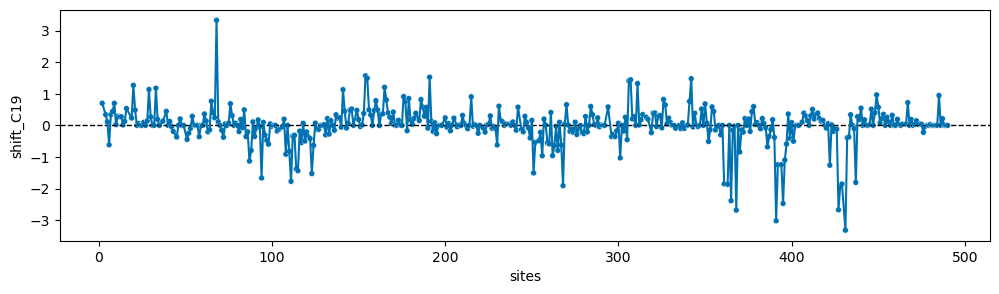

2 free
{'alpha_C19': Array([0.], dtype=float64), 'alpha_C9': Array([0.], dtype=float64), 'beta': Array([0.11120997, 0.23286523, 0.33328503, ..., 0.21958828, 0.29756256,
       0.29141463], dtype=float64), 'beta_naught': Array([0.68420934], dtype=float64), 'gamma_C19': Array([0.], dtype=float64), 'gamma_C9': Array([0.], dtype=float64), 'shift_C19': Array([ 0.,  0., -0., ...,  0.,  0.,  0.], dtype=float64), 'shift_C9': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64), 'theta': {'ghost_param': Array([0.], dtype=float64)}}


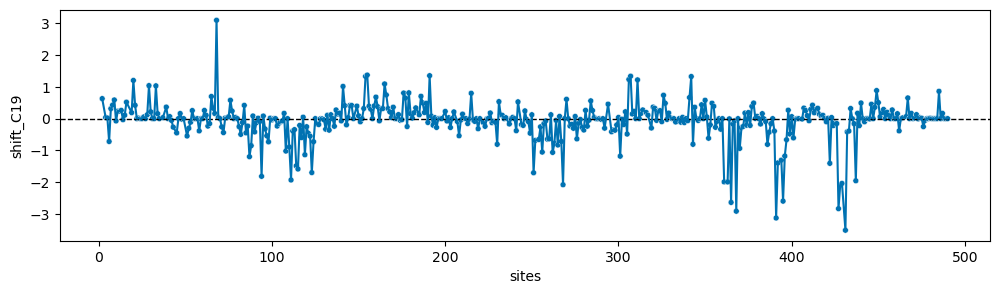

In [35]:
for idx, row in rep_fits.iterrows():
    print(row.replicate, row.beta_naught)
    print(row.model_20000.params)
    row.model_20000.plot_shifts_by_site("C19", times_seen_threshold=3, agg_func=onp.sum)

## Combine replicates, and shrinkage lasso params

In [36]:
models = pd.DataFrame()

In [37]:
data.condition_colors = {
    'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
    'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
}
# choose fitting hyper-parameters
fit_params = {
    'init_beta_naught' : 1.0,
    'lock_beta_naught' : None,
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'warmup_beta':False,
    'gamma_corrected':False,
    'alpha_d': True,
    'scale_coeff_ridge_beta':0,
    'scale_coeff_ridge_shift':0,
    'scale_coeff_ridge_gamma':0,
    'scale_coeff_ridge_ch':0,
    'tol':1e-4,
    'save_model_at':[30000],
    'num_training_steps': 30,
    'iterations_per_step':1000
}


for replicate, replicate_df in func_score_df.groupby("replicate"):
    data = multidms.Data(
        replicate_df.rename({target:"func_score"}, axis=1).reset_index(drop=True),
        reference = "C9",
        collapse_identical_variants = False,
        alphabet= multidms.AAS_WITHSTOP,
        verbose=True
    )
    for lasso in [0.0, 1e-06, 1e-05, 2e-05, 5e-05, 5e-4, 1e-4]:

        fit_params["scale_coeff_lasso_shift"] = lasso
        start_t = time.time()
        fit = multidms.utils.fit_wrapper(data, **fit_params)
        fit["target"] = target
        fit["replicate"] = replicate
    
        models = pd.concat([models, fit], ignore_index=True)
        end_t = time.time()
        print(f"FINISHED total time: {round(end_t - start_t)} seconds")
    
        print(f"Done")

inferring site map for C19


  0%|          | 0/318813 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/48946 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 197 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 3932 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f5e9b370110>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 1.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 0.0,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 0.2379289965073194, Time: 5 Seconds
training_step 1/30,Loss: 0.1544844322338871, Time: 4 Seconds
training_step 2/30,Loss: 0.12214271967876383, Time: 4 Seconds
training_step 3/30,Loss: 0.104

  0%|          | 0/212375 [00:00<?, ?it/s]

inferring site map for C9


  0%|          | 0/48927 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [1, 221, 38, 236],
dropping: 191 variantswhich have mutations at those sites.


invalid non-identical-sites: [3, 50, 184, 206, 243, 295, 362], dropping 2989 variants
Converting mutations for C19


Converting mutations for C9
is reference, skipping
running:
{'PRNGKey': 0,
 'alpha_d': True,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7f5e9a826850>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 1.0,
 'iterations_per_step': 1000,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'scale_coeff_lasso_shift': 0.0,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False}
training_step 0/30,Loss: 0.2381596175191904, Time: 5 Seconds
training_step 1/30,Loss: 0.15640113876399472, Time: 3 Seconds
training_step 2/30,Loss: 0.12465186043381672, Time: 4 Seconds
training_step 3/30,Loss: 0.10

In [39]:
import pickle
pickle.dump(models, open(f"{OUTDIR}/replicate-models.pkl", "wb"))

In [40]:
models

,dataset,huber_scale_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,target,replicate
0,<multidms.data.Data object at 0x7f5e9b370110>,1,0.0,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2379289965073194, 0.1544844322338871, 0.122...",<multidms.model.Model object at 0x7f5e8a9a7010>,abundance_score,1
1,<multidms.data.Data object at 0x7f5e9b370110>,1,0.000001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2390499471671071, 0.15522948102712497, 0.12...",<multidms.model.Model object at 0x7f5e68a33250>,abundance_score,1
2,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24297990499155994, 0.15647325466187811, 0.1...",<multidms.model.Model object at 0x7f5e64620c10>,abundance_score,1
3,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00002,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24326881291094504, 0.15711685411197018, 0.1...",<multidms.model.Model object at 0x7f5e95874e10>,abundance_score,1
4,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00005,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24987102999332644, 0.16036468145061214, 0.1...",<multidms.model.Model object at 0x7f5e9b2e0c10>,abundance_score,1
5,<multidms.data.Data object at 0x7f5e9b370110>,1,0.0005,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2606158330518405, 0.14844888200343018, 0.10...",<multidms.model.Model object at 0x7f5ea981ce10>,abundance_score,1
6,<multidms.data.Data object at 0x7f5e9b370110>,1,0.0001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.25922764467643905, 0.16206669686643352, 0.1...",<multidms.model.Model object at 0x7f5e9a5af010>,abundance_score,1
7,<multidms.data.Data object at 0x7f5e9a826850>,1,0.0,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2381596175191904, 0.1564011387639947, 0.124...",<multidms.model.Model object at 0x7f5cf44dce10>,abundance_score,2
8,<multidms.data.Data object at 0x7f5e9a826850>,1,0.000001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24023963384091634, 0.15726694006081787, 0.1...",<multidms.model.Model object at 0x7f5cdc414e10>,abundance_score,2
9,<multidms.data.Data object at 0x7f5e9a826850>,1,0.00001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24552584976298847, 0.15868650547917063, 0.1...",<multidms.model.Model object at 0x7f5cdcb9fdd0>,abundance_score,2


In [43]:
mut_df = multidms.utils.combine_replicate_muts(
    {
        f"Rep{row.replicate}_lasso_{row.scale_coeff_lasso_shift}" : row.model_30000
        for idx, row in models.iterrows()   
    }
)

In [44]:
mut_df

,wts,sites,muts,Rep1_lasso_0.0_beta,Rep1_lasso_1e-06_beta,Rep1_lasso_1e-05_beta,Rep1_lasso_2e-05_beta,Rep1_lasso_5e-05_beta,Rep1_lasso_0.0005_beta,Rep1_lasso_0.0001_beta,...,Rep1_lasso_0.0005_C9_predicted_func_score,Rep1_lasso_0.0001_C9_predicted_func_score,Rep2_lasso_0.0_C9_predicted_func_score,Rep2_lasso_1e-06_C9_predicted_func_score,Rep2_lasso_1e-05_C9_predicted_func_score,Rep2_lasso_2e-05_C9_predicted_func_score,Rep2_lasso_5e-05_C9_predicted_func_score,Rep2_lasso_0.0005_C9_predicted_func_score,Rep2_lasso_0.0001_C9_predicted_func_score,avg_C9_predicted_func_score
mutation,,,,,,,,,,,,,,,,,,,,,
D2A,D,2,A,0.058504,0.063596,0.109601,0.137905,0.135783,0.133539,0.133857,...,0.133539,0.133857,0.070885,0.075940,0.114641,0.113860,0.111592,0.107758,0.109335,0.105485
D2C,D,2,C,0.541015,0.539706,0.479710,0.474384,0.472465,0.470639,0.470778,...,0.470639,0.470778,0.174155,0.186738,0.239522,0.239386,0.237353,0.234153,0.235394,0.356814
D2E,D,2,E,0.196774,0.202538,0.245075,0.244177,0.241996,0.239726,0.240047,...,0.239726,0.240047,0.365326,0.360983,0.338698,0.337872,0.335568,0.331714,0.333287,0.286699
D2F,D,2,F,-0.264731,-0.252259,-0.140296,-0.112983,-0.114614,-0.116600,-0.116298,...,-0.116600,-0.116298,0.483673,0.471938,0.382404,0.381743,0.379668,0.376213,0.377612,0.123962
D2G,D,2,G,0.195744,0.197736,0.214999,0.233233,0.241298,0.239314,0.239600,...,0.239314,0.239600,0.200432,0.202369,0.218399,0.236010,0.245470,0.241856,0.243440,0.224993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V490F,V,490,F,0.223611,0.233658,0.262327,0.261502,0.258325,0.256625,0.256442,...,0.256625,0.256442,0.079216,0.089401,0.142912,0.142103,0.139032,0.136704,0.137016,0.187062
V490G,V,490,G,-0.175190,-0.168728,-0.116790,-0.117692,-0.119858,-0.122117,-0.121797,...,-0.122117,-0.121797,-0.082732,-0.076192,-0.040065,-0.040886,-0.043174,-0.047012,-0.045445,-0.094120
V490L,V,490,L,0.428174,0.421482,0.363816,0.363301,0.361577,0.359532,0.359828,...,0.359532,0.359828,0.292704,0.286033,0.226912,0.226371,0.224362,0.220712,0.222278,0.311220


In [45]:
mut_df.columns

Index(['wts', 'sites', 'muts', 'Rep1_lasso_0.0_beta', 'Rep1_lasso_1e-06_beta',
       'Rep1_lasso_1e-05_beta', 'Rep1_lasso_2e-05_beta',
       'Rep1_lasso_5e-05_beta', 'Rep1_lasso_0.0005_beta',
       'Rep1_lasso_0.0001_beta', 'Rep2_lasso_0.0_beta',
       'Rep2_lasso_1e-06_beta', 'Rep2_lasso_1e-05_beta',
       'Rep2_lasso_2e-05_beta', 'Rep2_lasso_5e-05_beta',
       'Rep2_lasso_0.0005_beta', 'Rep2_lasso_0.0001_beta', 'avg_beta',
       'Rep1_lasso_0.0_shift_C19', 'Rep1_lasso_1e-06_shift_C19',
       'Rep1_lasso_1e-05_shift_C19', 'Rep1_lasso_2e-05_shift_C19',
       'Rep1_lasso_5e-05_shift_C19', 'Rep1_lasso_0.0005_shift_C19',
       'Rep1_lasso_0.0001_shift_C19', 'Rep2_lasso_0.0_shift_C19',
       'Rep2_lasso_1e-06_shift_C19', 'Rep2_lasso_1e-05_shift_C19',
       'Rep2_lasso_2e-05_shift_C19', 'Rep2_lasso_5e-05_shift_C19',
       'Rep2_lasso_0.0005_shift_C19', 'Rep2_lasso_0.0001_shift_C19',
       'avg_shift_C19', 'Rep1_lasso_0.0_C19_predicted_func_score',
       'Rep1_lasso_1e-06_C19_

In [46]:
cols_to_keep = ["wts", "sites", "muts"] + [c for c in mut_df.columns if "shift" in c and "avg" not in c]
print(cols_to_keep)

['wts', 'sites', 'muts', 'Rep1_lasso_0.0_shift_C19', 'Rep1_lasso_1e-06_shift_C19', 'Rep1_lasso_1e-05_shift_C19', 'Rep1_lasso_2e-05_shift_C19', 'Rep1_lasso_5e-05_shift_C19', 'Rep1_lasso_0.0005_shift_C19', 'Rep1_lasso_0.0001_shift_C19', 'Rep2_lasso_0.0_shift_C19', 'Rep2_lasso_1e-06_shift_C19', 'Rep2_lasso_1e-05_shift_C19', 'Rep2_lasso_2e-05_shift_C19', 'Rep2_lasso_5e-05_shift_C19', 'Rep2_lasso_0.0005_shift_C19', 'Rep2_lasso_0.0001_shift_C19']


In [47]:
mut_df[cols_to_keep].to_csv(f"{OUTDIR}/replicate_shift_lasso_sweep.csv")

In [48]:
# import pickle

In [49]:
# models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))

In [50]:
# set some global variables
# columns name
model_name = "model_30000"

# the number of times a mutation must be seen in each condition to be included in downstream analysis
times_seen_threshold = 3

# The chosen lasso strength for our final spike model results
chosen_lasso_strength = 0.00001

In [51]:
models

,dataset,huber_scale_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,target,replicate
0,<multidms.data.Data object at 0x7f5e9b370110>,1,0.0,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2379289965073194, 0.1544844322338871, 0.122...",<multidms.model.Model object at 0x7f5e8a9a7010>,abundance_score,1
1,<multidms.data.Data object at 0x7f5e9b370110>,1,0.000001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2390499471671071, 0.15522948102712497, 0.12...",<multidms.model.Model object at 0x7f5e68a33250>,abundance_score,1
2,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24297990499155994, 0.15647325466187811, 0.1...",<multidms.model.Model object at 0x7f5e64620c10>,abundance_score,1
3,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00002,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24326881291094504, 0.15711685411197018, 0.1...",<multidms.model.Model object at 0x7f5e95874e10>,abundance_score,1
4,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00005,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24987102999332644, 0.16036468145061214, 0.1...",<multidms.model.Model object at 0x7f5e9b2e0c10>,abundance_score,1
5,<multidms.data.Data object at 0x7f5e9b370110>,1,0.0005,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2606158330518405, 0.14844888200343018, 0.10...",<multidms.model.Model object at 0x7f5ea981ce10>,abundance_score,1
6,<multidms.data.Data object at 0x7f5e9b370110>,1,0.0001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.25922764467643905, 0.16206669686643352, 0.1...",<multidms.model.Model object at 0x7f5e9a5af010>,abundance_score,1
7,<multidms.data.Data object at 0x7f5e9a826850>,1,0.0,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2381596175191904, 0.1564011387639947, 0.124...",<multidms.model.Model object at 0x7f5cf44dce10>,abundance_score,2
8,<multidms.data.Data object at 0x7f5e9a826850>,1,0.000001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24023963384091634, 0.15726694006081787, 0.1...",<multidms.model.Model object at 0x7f5cdc414e10>,abundance_score,2
9,<multidms.data.Data object at 0x7f5e9a826850>,1,0.00001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24552584976298847, 0.15868650547917063, 0.1...",<multidms.model.Model object at 0x7f5cdcb9fdd0>,abundance_score,2


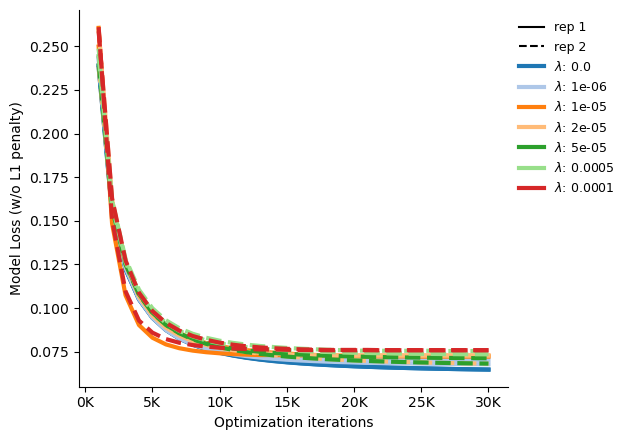

In [52]:
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        # linestyle="--",
        linestyle="-" if model_row.replicate == "1" else "--",
        label=f"scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )

ticks = range(0, 30001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)
ax.set_ylim()
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
plt.show()

In [54]:
models = models.sort_values("scale_coeff_lasso_shift").reset_index(drop=True)

0.0


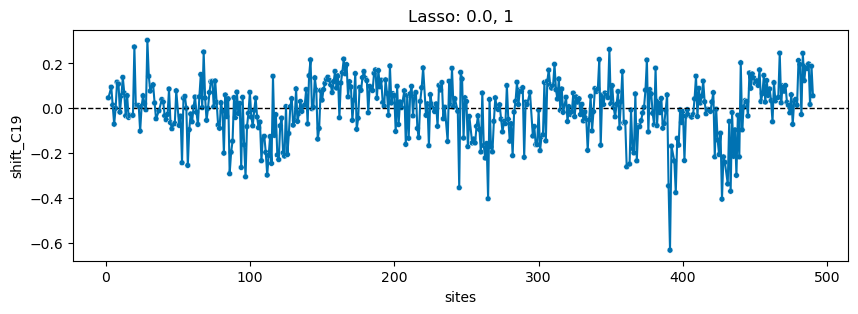

0.0


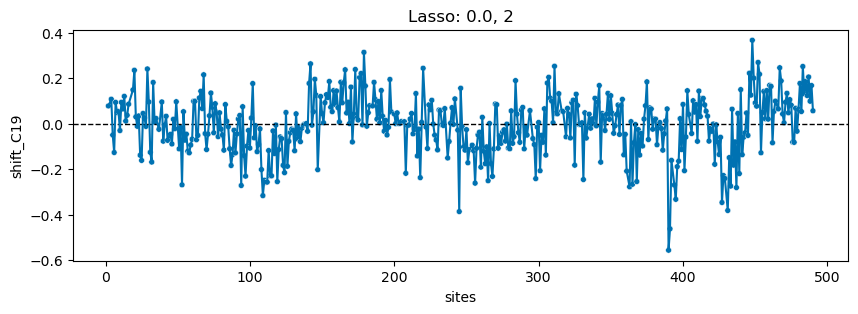

1e-06


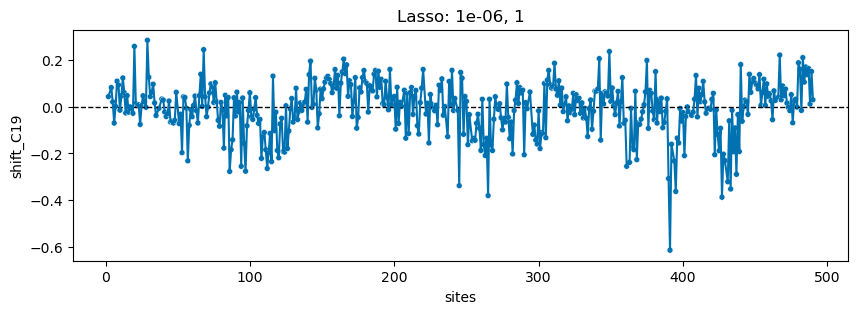

1e-06


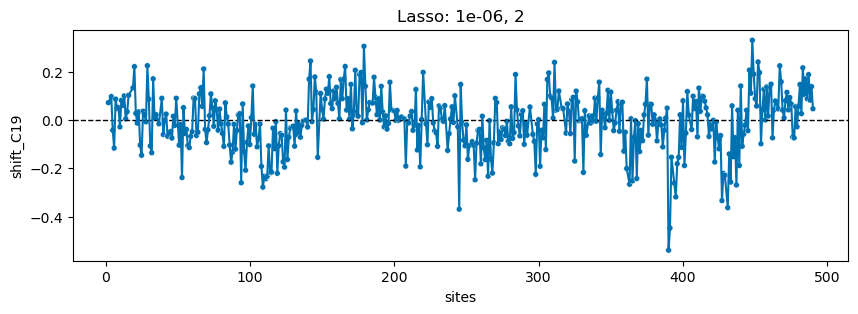

1e-05


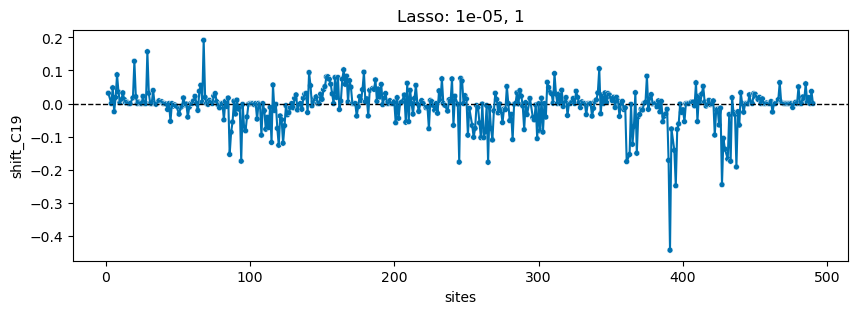

1e-05


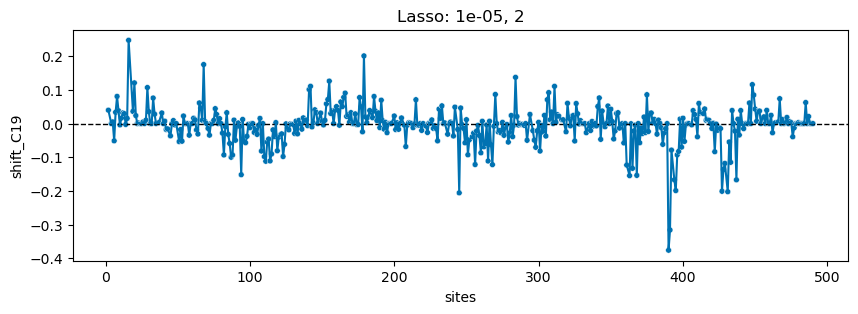

2e-05


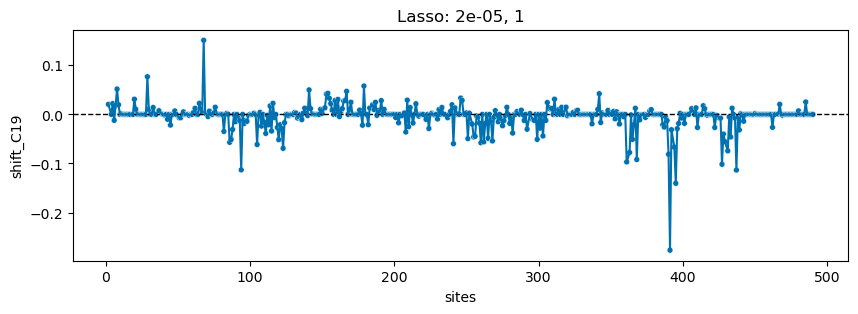

2e-05


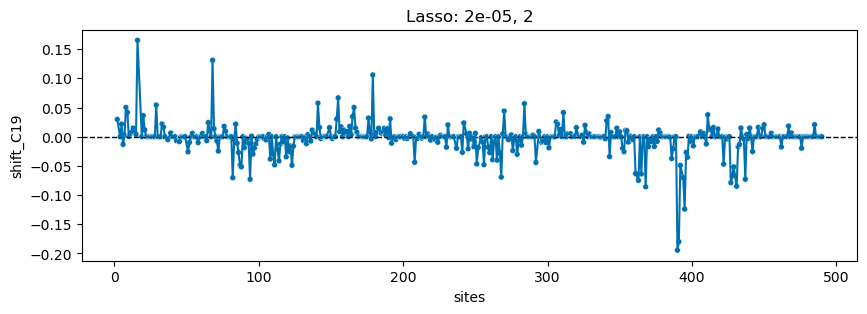

5e-05


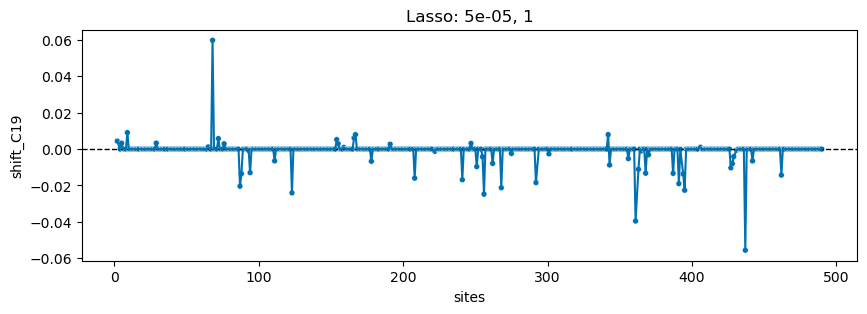

5e-05


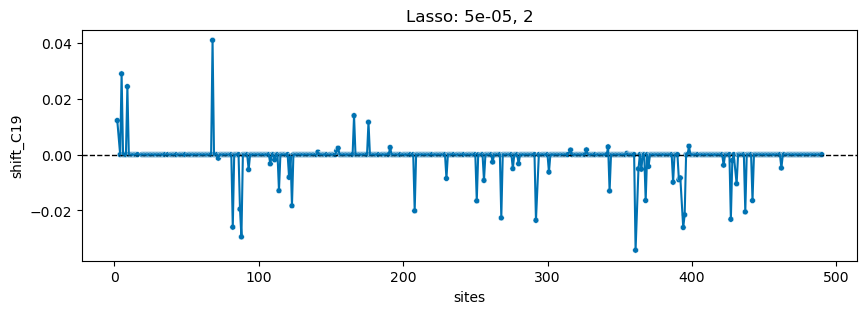

0.0001


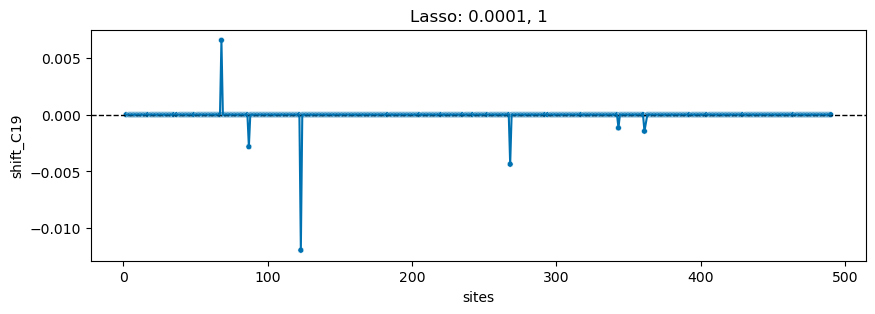

0.0001


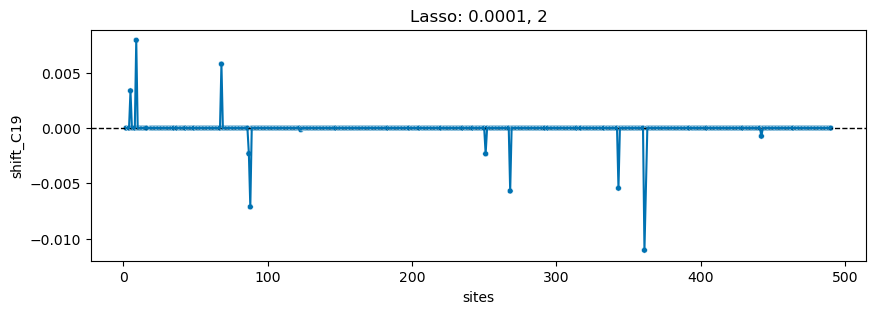

0.0005


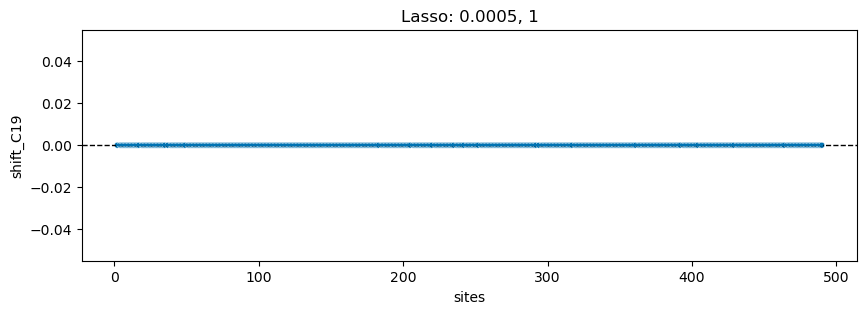

0.0005


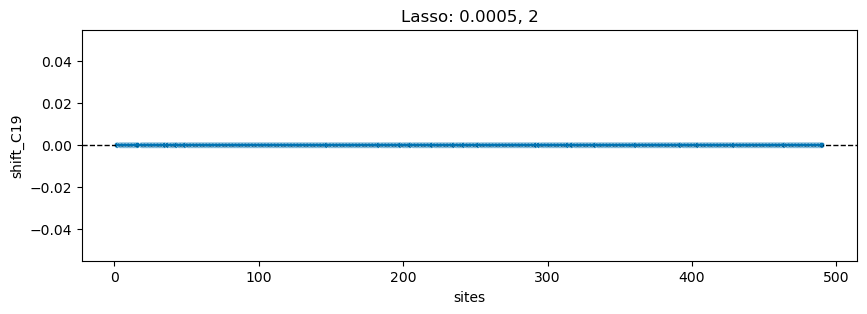

In [55]:
for idx, model in models.iterrows():
    fig, ax = plt.subplots(figsize=(10, 3))
    print(model.scale_coeff_lasso_shift)
    model[model_name].plot_shifts_by_site(
        "C19", 
        times_seen_threshold=times_seen_threshold, 
        agg_func=onp.mean,
        show=False,
        ax=ax
    )
    ax.set_title(f"Lasso: {model.scale_coeff_lasso_shift}, {model.replicate}")
    plt.show()
    # fig.savefig(f"{OUTDIR}/shifts_by_site_lasso_{model.scale_coeff_lasso_shift}.pdf")

In [56]:
models

,dataset,huber_scale_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,target,replicate
0,<multidms.data.Data object at 0x7f5e9b370110>,1,0.0,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2379289965073194, 0.1544844322338871, 0.122...",<multidms.model.Model object at 0x7f5e8a9a7010>,abundance_score,1
1,<multidms.data.Data object at 0x7f5e9a826850>,1,0.0,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2381596175191904, 0.1564011387639947, 0.124...",<multidms.model.Model object at 0x7f5cf44dce10>,abundance_score,2
2,<multidms.data.Data object at 0x7f5e9b370110>,1,0.000001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.2390499471671071, 0.15522948102712497, 0.12...",<multidms.model.Model object at 0x7f5e68a33250>,abundance_score,1
3,<multidms.data.Data object at 0x7f5e9a826850>,1,0.000001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24023963384091634, 0.15726694006081787, 0.1...",<multidms.model.Model object at 0x7f5cdc414e10>,abundance_score,2
4,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24297990499155994, 0.15647325466187811, 0.1...",<multidms.model.Model object at 0x7f5e64620c10>,abundance_score,1
5,<multidms.data.Data object at 0x7f5e9a826850>,1,0.00001,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24552584976298847, 0.15868650547917063, 0.1...",<multidms.model.Model object at 0x7f5cdcb9fdd0>,abundance_score,2
6,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00002,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24326881291094504, 0.15711685411197018, 0.1...",<multidms.model.Model object at 0x7f5e95874e10>,abundance_score,1
7,<multidms.data.Data object at 0x7f5e9a826850>,1,0.00002,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24461790507012773, 0.159324990215236, 0.126...",<multidms.model.Model object at 0x7f5e8a854e10>,abundance_score,2
8,<multidms.data.Data object at 0x7f5e9b370110>,1,0.00005,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24987102999332644, 0.16036468145061214, 0.1...",<multidms.model.Model object at 0x7f5e9b2e0c10>,abundance_score,1
9,<multidms.data.Data object at 0x7f5e9a826850>,1,0.00005,0,0,0,0,0,Identity,Identity,...,False,0.0001,30,1000,[30000],0,"[0.24874816939868938, 0.16153378330147677, 0.1...",<multidms.model.Model object at 0x7f5d14364e10>,abundance_score,2


In [55]:
# fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in models.iterrows()}

# mut_df = multidms.utils.combine_replicate_muts(
#     fit_dict, 
#     times_seen_threshold=times_seen_threshold, 
#     how="outer"
# )

# mut_df = pd.melt(
#     mut_df.reset_index(), 
#     id_vars=["mutation"],
#     value_vars=[
#         col for col in mut_df.columns 
#         if ("_shift_" in col or "beta" in col) and "avg" not in col
#     ],
#     value_name="S"
# )

# mut_df = mut_df.assign(
#     scale_coeff_lasso=[ 
#         v.split("_")[1]
#         for v in mut_df.variable
#     ],
#     sense=[
#         "stop" if "*" in mut else "nonsynonymous"
#         for mut in mut_df.mutation
#     ],
#     condition=[
#         "C9" 
#         if "beta" in v
#         else "C19" 
#         for v in mut_df.variable
#     ],
#     # replicate=replicate
# )

# mut_df.drop("variable", axis=1, inplace=True)
# tall_mut_df = mut_df

In [58]:
models["replicate"] = models.replicate.replace({"1": 0, "2": 1})

In [59]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    mut_df.rename(
        {
            bc : f"{bc}_C9"
            for bc in mut_df.columns
            if "beta" in bc
        }, 
        axis=1, 
        inplace=True
    )

    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if ("_shift_" in col or "beta" in col) and "avg" not in col
        ],
        value_name="S"
    )
    
    mut_df = mut_df.assign(
        scale_coeff_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "stop" if "*" in mut else "nonsynonymous"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df.sample(10, random_state=23)

,mutation,S,scale_coeff_lasso,sense,condition,replicate
44493,H251*,0.000000,1e-05,stop,C19,1
27384,I215W,0.365240,0.0001,nonsynonymous,C9,0
15543,E154D,0.274718,2e-05,nonsynonymous,C9,1
1461,R139S,0.298274,0.0,nonsynonymous,C9,0
8856,M426G,-0.080348,1e-06,nonsynonymous,C9,1
56695,R139W,0.000000,5e-05,nonsynonymous,C19,0
14765,K84Q,0.183612,2e-05,nonsynonymous,C9,1
12883,D360S,0.220018,1e-05,nonsynonymous,C9,1
59141,C372A,0.000000,5e-05,nonsynonymous,C19,0
23950,H368T,-0.058240,5e-05,nonsynonymous,C9,0


In [83]:
# import jax
# def loss(model, condition):
#     kwargs = {
#         'scale_coeff_ridge_beta': 0.,
#         'scale_coeff_ridge_shift': 0.,
#         'scale_coeff_ridge_gamma': 0.
#     }
    
#     data = (
#         {condition:model.data.training_data["X"][condition]}, 
#         {condition:model.data.training_data["y"][condition]}
#     )
    
#     params = model.get_condition_params(condition)
#     return jax.jit(model._model_components["objective"])(model.params, data)

# lasso_sparsity_loss = defaultdict(list)
# for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
#     lasso_sparsity_loss["lasso"].append(str(lasso))
#     model = lasso_replicates[model_name].values[0]
#     muts_df_outer = model.get_mutations_df(phenotype_as_effect=False)
#     muts_df_outer = muts_df_outer.assign(
#         sense = [
#             "stop" if "*" in mut else "nonsynonymous"
#             for mut in muts_df_outer.index.values
#         ]
#     )

#     muts_df_inner = muts_df_outer.dropna()
#     for cond in model.data.conditions:
#         if cond == model.data.reference:

#             rep_cond_shifts = muts_df_outer[[f"beta", "sense"]].dropna()
#             for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
#                 shifts = rep_cond_shifts.query("sense == @sense")[f"beta"]
#                 sparsity = (len(shifts[onp.isclose(shifts, 0, 1e-8)]) / len(shifts))*100
#                 lasso_sparsity_loss[f"{cond}-{sense}-sparsity"].append(sparsity)

#         else:
            
#             rep_cond_shifts = muts_df_outer[[f"shift_{cond}", "sense"]].dropna()
#             for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
#                 shifts = rep_cond_shifts.query("sense == @sense")[f"shift_{cond}"]
#                 sparsity = (len(shifts[onp.isclose(shifts, 0, 1e-8)]) / len(shifts))*100
#                 lasso_sparsity_loss[f"{cond}-{sense}-sparsity"].append(sparsity)
            

#         lasso_sparsity_loss[f"{cond}-loss"].append(loss(model, cond))

# lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
# lasso_sparsity_loss

In [62]:
import numpy as np
import jax

In [63]:
def loss(model, condition):
    kwargs = {
        'scale_coeff_ridge_beta': 0.,
        'scale_coeff_ridge_shift': 0.,
        'scale_coeff_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "nonsynonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    for cond in model.data.conditions:
        if cond == model.data.reference:
            

            if np.all(muts_df_inner[f"0_beta"] <= 0.05) or np.all(muts_df_inner[f"1_beta"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_beta"], muts_df_inner[f"1_beta"])
                r = corr[0]
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_beta", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_beta"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)

        else:
            if np.all(muts_df_inner[f"0_shift_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_shift_{cond}"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_shift_{cond}"], muts_df_inner[f"1_shift_{cond}"])
                r = corr[0]
                r = np.nan if np.isclose(r, 1.0) else r
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_shift_{cond}", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_shift_{cond}"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,C19-replicate-correlation,C19-0-stop-sparsity,C19-0-nonsynonymous-sparsity,C19-1-stop-sparsity,C19-1-nonsynonymous-sparsity,C9-replicate-correlation,C9-0-stop-sparsity,C9-0-nonsynonymous-sparsity,C9-1-stop-sparsity,C9-1-nonsynonymous-sparsity,C19-0-loss,C9-0-loss,C19-1-loss,C9-1-loss
0,0.0,0.551217,0.000000,0.000000,0.000000,0.000000,0.828272,0.0,0.0,0.0,0.0,0.013151216746287163,0.05159240300429495,0.024128801459804252,0.04401658788511663
1,1e-06,0.552673,3.658537,6.985220,8.450704,5.213991,0.835277,0.0,0.0,0.0,0.0,0.013223801051006985,0.05154856399414739,0.024204468853687232,0.04397322053121116
2,1e-05,0.598832,86.585366,66.774651,85.915493,63.610689,0.888541,0.0,0.0,0.0,0.0,0.015084121438187723,0.05270387178266539,0.026116351734948053,0.045136705630322266
3,2e-05,0.655984,100.000000,86.819194,98.591549,86.291549,0.912343,0.0,0.0,0.0,0.0,0.016110103179566446,0.05403424535378453,0.02714045202492578,0.04641968352665495
4,5e-05,0.644314,100.000000,98.400486,100.000000,98.283728,0.921964,0.0,0.0,0.0,0.0,0.016936968564459514,0.05523556874031181,0.02790693540576117,0.04748836067799199
5,0.0001,0.292423,100.000000,99.858271,100.000000,99.717575,0.922831,0.0,0.0,0.0,0.0,0.01716464628659872,0.055553470674902676,0.028139052420263728,0.04775228266754168
6,0.0005,NaN,100.000000,100.000000,100.000000,100.000000,0.922913,0.0,0.0,0.0,0.0,0.017178182045735377,0.05556796281633249,0.02810496144871624,0.04772727670428654


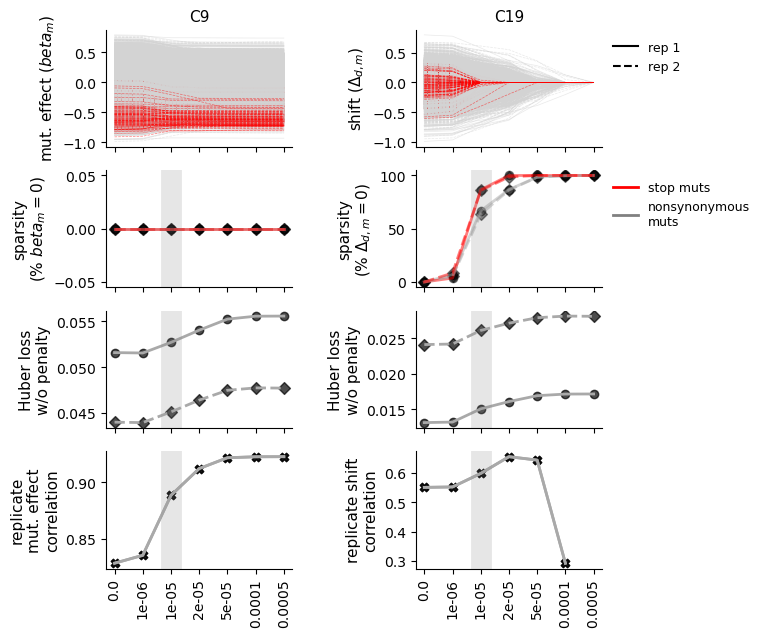

In [65]:
saveas="shrinkage_analysis_trace_plots_beta"
fig, ax = plt.subplots(
    4,3, 
    figsize=[6.4,7],
    sharex=True, 
    gridspec_kw={
        'width_ratios': [1,0.35,1]
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

# mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
# mutations_cmap=plt.get_cmap("Accent").colors
# mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "C9" : 0,
    "C19" : 2,
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.5
}

sense_alpha = {
    "nonsynonymous" : 0.5,
    "stop" : 0.5
}

model_choice = chosen_lasso_strength
model_line_kwargs = {
    "linewidth" : 15,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    # replicate=1
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    # plot nonsynonymous, non validated
    for mut, trace_df in df.query(
        "sense == 'nonsynonymous'"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['nonsynonymous'],
            alpha=sense_alpha['nonsynonymous'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # # plot highlighted muts
    # for mut, trace_df in df.query(
    #     "mutation.isin(@mutations_to_highlight)"
    # ).groupby("mutation"):
    #     iter_ax.plot(
    #         trace_df.scale_coeff_lasso, 
    #         trace_df.S,
    #         linestyle=replicate_line_style[replicate],
    #         linewidth=2,
    #         alpha=1.0,
    #         color=mutations_cmap[mut]
    #     )
    # iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    



ax[0, 0].set_title("C9", size=11)
ax[0, 2].set_title("C19", size=11)
# ax[0, 3].set_title("BA.2", size=11)

ax[0, 1].set_visible(False)
ax[1, 1].set_visible(False)
ax[2, 1].set_visible(False)
ax[3, 1].set_visible(False)

ax[0, 0].set_ylabel("mut. effect ($beta_{m}$)", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $beta_{m} = 0$)", size=11)
# ax[2, 0].set_ylabel("condition\n train data loss \n$L_{Huber_{\sigma=1}}^{d}$ w/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[2, 0].set_ylabel("Huber loss\nw/o penalty", size=11)
ax[3, 0].set_ylabel("replicate\nmut. effect\ncorrelation", size=11)

ax[0, 2].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 2].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
# ax[2, 2].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[2, 2].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[3, 2].set_ylabel("replicate shift\ncorrelation", size=11)


# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
# lasso_color_handles = [
#     mlines.Line2D(
#         [], [], 
#         color=color, 
#         linestyle='-',
#         markersize=2,
#         linewidth=2,
#         label=mut
#     )
#     for mut, color in mutations_cmap.items()
# ]

elements = [black_line, black_dashed] 
ax[0,2].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop muts')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous\nmuts')

elements = [red_line, grey_line] #+lasso_color_handles
ax[1, 2].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)


# ax[0,0].text(
#     -0.55, 1.00, 
#     f"A", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[0,0].transAxes
# )
# ax[1,0].text(
#     -0.55, 1.00, 
#     f"B", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[1,0].transAxes
# )
# ax[2,0].text(
#     -0.55, 1.00, 
#     f"C", 
#     ha="right", va="center", 
#     size=15,
#     weight="bold",
#     transform=ax[2,0].transAxes
# )

# ax[0, 2].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
# ax[0, 2].set_ylim([-3.0, 4.5])
# ax[0, 3].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
# ax[0, 3].set_ylim([-3.0, 4.5])
# ax[0, 3].yaxis.set_tick_params(labelleft=False)

# ax[1, 2].set_yticks([0, 50, 100], [0, 50, 100])
# ax[1, 2].set_ylim([-5, 105])
# ax[1, 3].set_yticks([0, 50, 100], [0, 50, 100])
# ax[1, 3].set_ylim([-5, 105])
# ax[1, 3].yaxis.set_tick_params(labelleft=False)

# ax[2, 2].set_yticks([.1, .2, .3], [.1, .2, .3])
# ax[2, 2].set_ylim([.15, .35])
# ax[2, 3].set_yticks([.1, .2, .3], [.1, .2, .3])
# ax[2, 3].set_ylim([.15, .35])
# ax[2, 3].yaxis.set_tick_params(labelleft=False)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=90, ha='center')
ax[3,2].set_xticks(ax[3,2].get_xticks(), ax[3,2].get_xticklabels(), rotation=90, ha='center')

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.svg",bbox_inches='tight')
plt.show()